# SATURNN functions

**References for this algorithm** :

(English)

Marie Guyomard, Susana Barbosa, Lionel Fillatre, Kernel Logistic Regression Approximation of an Understandable ReLU Neural Network, International Conference on Machine Learning (ICML), 2023.

Marie Guyomard, Susana Barbosa, Lionel Fillatre, Understandable ReLU Neural Network for signal classification, International Conference on Acoustics, Speech, and Signal Processing (ICASSP), 2023.

(French)

Marie Guyomard, Susana Barbosa, Lionel Fillatre, R ́egression Logistique à Noyau équivalente à un Réseau de Neurones Interprétable, Groupe de Recherche et d’Etudes de Traitement du Signal et des Images (Gretsi), 2023.

Marie Guyomard, Susana Barbosa, Lionel Fillatre, Approximation d’un Réseau de Neurones ReLU interprétable par une Régression Logistique à Noyau, Journées de la Statistique (JDS), 2023.


**Table of contents**

This notebook provides the following methods :
- A class functions for SATURNN
- A function to train the SATURNN with cross-validation
- A class functions to plot the splines estimated per variable by the SATURNN
- A class function to plot the decision boundary (only for 2-D variables)
- A class functions to compute the accuracies of the SATURNN : global accuracy, accuracies per class and AUC
- A function in order to check the convergence of the SATURNN during its training process

## Required Packages

In [1]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math
import os
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
import random
from sklearn.utils import class_weight
from tqdm import tqdm, trange, tnrange
import time
import statistics

## SATURNN

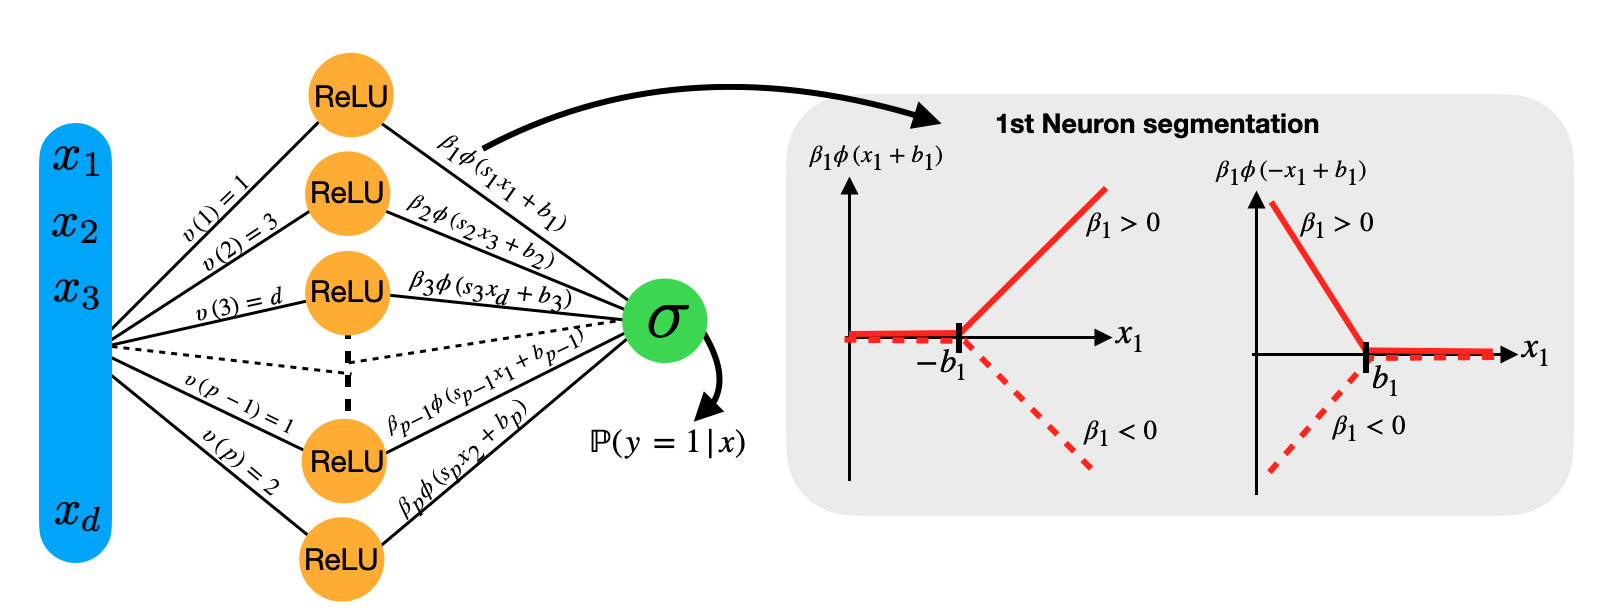

In [6]:
from IPython import display
display.Image('Schema_SATURNN.png', width=2000)

**Modeling**

The SATURNN is a 1-Layer Neural Network for classification:
$$\Phi^\text{SATURNN}(x,\theta) = \sigma(\psi(x, \theta)),$$
with 
$\sigma$ the sigmoid activation:
$$\sigma(x) = \frac{1}{1+\exp(-x)},$$
and $\psi(x,\theta)$ the score function defined by :
$$\psi(x, \theta) = \frac{1}{\sqrt p} \left[ \beta_0 + \sum_{k=1}^p \beta_k \phi(s_kx_{\upsilon(k)} + b_k) \right],$$
with $\theta = [\beta^T, b^T]^T \in \mathbb{R}^{2p+1}$ are the trainable parameters and $x^T$ is the transpose of $x$ such that $x \in \mathcal{B}_2^d(0,r)$, $r>0$.

For the neuron $k$, we have:
- $\upsilon_k = \{1,\ldots,d\}$ is the input selector indicating which feature is handled by the neuron
- $b_k$ is the threshold from which the non-linear effect will be created
- $s_k = \{-1,1\}$ indicates if the non-linear effect will be created on the left or on the right of the treshold $b_k$
- $\beta_k$ indicates the impact of the non-linear effect on the estimated probability



**Initialization Process**


For all $k \in \{1, \dots, p\}$:
- Fixed Parameters after initialization
    - $\upsilon_k(x) \sim \mathcal{U}[\![ 1, d]\!]$
    - $s_k \sim \mathcal{B}(1/2)$
- Trainable parameters : $\theta^{(0)} = [\beta_0^{(0)}, \beta_1^{(0)}, \dots, \beta_p^{(0)}, b_1^{(0)}, \dots, b_p^{(0)}]$
    - $b_k \sim \mathcal{U}[-r, r]$
    - $\beta_k \sim \mathcal{N}(0,1)$
    
    
    
    
**Learning of the SATURNN**

Learning SATURNN requires to minimize the following cost function:
$$\mathcal{L}^{\text{SATURNN}}(\theta)= \frac{1}{N} \sum_{i=1}^N L\left(\sigma(\psi(x^{(i)}, \theta)), y^{(i)}\right),$$
such that
$$\hat{\theta}^{\text{SATURNN}} = \arg\min_{\theta \in \mathcal{B}_2^{2p+1}(\theta^{(0)}, R)}   \mathcal{L}^{\text{SATURNN}}(\theta),$$
with $L(\cdot)$ the binary cross-entropy used for binary classification tasks 
$$L\left(\hat{y}, y\right)=-y\log(\hat{y})-(1-y)\log(1-\hat{y}).$$



In [3]:
class SATURNN(nn.Module):
    def __init__(self, X, nb_neurones, r):
        '''
        Parameters
        ----------
        X : DataFrame
            Features.
        nb_neurones : int
            Number of nodes in the hidden layer.
        r : float
            Radius of input space ball.

        Returns
        -------
        None.

        '''
     
        super(SATURNN, self).__init__()
        
        self.X = X
        self.nb_neurones = nb_neurones
        self.r = r
        
        input_size = self.X.shape[1]
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        # Create hidden layer
        self.input_layer = nn.Linear(input_size, self.nb_neurones)#.to(device)
        wj = torch.zeros(self.nb_neurones,input_size, requires_grad=False).to(device)
        #bj = torch.zeros(self.nb_neurones, requires_grad=False).to(device)
        for j in range(self.nb_neurones):
            ej = np.random.randint(low=0, high=input_size)
            wj[j][ej] = 1
            if np.random.binomial(1, 0.5, 1)==0:
                wj[j] = -wj[j]
        b = torch.Tensor(np.random.uniform(-self.r,self.r,self.nb_neurones)).to(device)
        self.input_layer.weight = torch.nn.Parameter(wj, requires_grad=False).to(device)
        self.input_layer.bias = torch.nn.Parameter(b, requires_grad=True).to(device)
        
        # Create output layer
        self.output_layer = nn.Linear(self.nb_neurones, 1).to(device)
        nn.init.normal_(self.output_layer.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.output_layer.bias, mean=0.0, std=1.0)
        self.sigmoide = nn.Sigmoid().to(device)
        
        self._init = {'beta_0':np.array(self.output_layer.state_dict()['bias'].cpu().detach().numpy().copy()),
              'beta':np.array(self.output_layer.state_dict()['weight'].cpu().detach().numpy().copy()),
              'w':np.array(self.input_layer.state_dict()['weight'].cpu().detach().numpy().copy()),
              'b':np.array(self.input_layer.state_dict()['bias'].cpu().detach().numpy().copy())}
       
        
    
    def forward(self, input_data, dropout_rate=0):
        '''
        Parameters
        ----------
        input_data : Tensor
            Features.
        dropout_rate : float
            If '0' no dropout. Else some node will be forced to be zero with a probability equal to dropout_rate. Default=0.

        Returns
        -------
        predictions : tensor
            Output of the neural network.

        '''
        
        d = self.X.shape[1]
        
        output = self.input_layer(input_data)
        output = F.relu(output)
        
        if dropout_rate != 0 :
            output = self.dropout(output)
        
        output = self.output_layer(output)
        output = (1/math.sqrt(self.nb_neurones)) * output
        predictions = self.sigmoide(output)
        
        return predictions
    
    
    def backward(self, optimizer, loss):
        '''
        Parameters
        ----------
        optimizer : torch.optim
            Optimization algorithm.
        loss : tensor
            Loss.
    
        Returns
        -------
        None.
    
        '''
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    def l2_reg_loss(self):
        return np.sum(np.square((np.concatenate((np.array(self.output_layer.state_dict()['bias'].cpu().detach().numpy().copy()), np.array(self.output_layer.state_dict()['weight'][0].cpu().detach().numpy().copy()), np.array(self.input_layer.state_dict()['bias'].cpu().detach().numpy().copy()))) - np.concatenate((self._init['beta_0'], self._init['beta'][0], self._init['b'])))))
            
    
    def training_step(self, Xtrain, Ytrain, option_balanced, l2_reg, dropout_rate, learning_rate, K):
        '''
        Parameters
        ----------
        Xtrain : Tensor
            Features of the training sample.
        Ytrain : Tensor
            Labels of the training sample.
        option_balanced : boolean
            True ; balanced binary cross entropy loss. False ; binary cross entropy loss.
        l2_reg : float 
            Hyperparameter for Lasso regularization . If 0 no regularization addeed.
        dropout_rate : float
            If '0' no dropout. Else some node will be forced to be zero with a probability equal to dropout_rate.
        learning_rate : float
            Learning rate.
        K : int
            Number of classes.
    
        Returns
        -------
        loss : tensor
            Loss.
        piTrain : array
            Class proportions of the training sample.
        RTrain : array
            Conditional risks on the training sample.
        rTrain : float
            Empirical risk on the training sample.
        aucTrain : float
            AUC on the testing sample
        '''
        
        # Predictions
        Proba_train = self.forward(Xtrain.float(), dropout_rate) 

    
        Yhat_train = []
        for i in range(len(Proba_train.cpu().detach().numpy())):
            if Proba_train.cpu().detach().numpy()[i] >= 0.5 :
                Yhat_train.append(int(1))
            else :
                Yhat_train.append(int(0))
                          
                
        # Loss
        if option_balanced == True :
            reponderation = torch.Tensor(class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(np.array(Ytrain)), y = np.array(Ytrain))).to(device)
            weights = torch.Tensor(np.zeros(Ytrain.shape[0])).to(device)
            for i in range(Ytrain.shape[0]) :
                if Ytrain[i]==0 :
                    weights[i]=reponderation[0] 
                else :
                    weights[i]=reponderation[1] 
            
            loss = nn.BCELoss(weight=weights)(Proba_train.view(Xtrain.shape[0]), Ytrain.float()) - l2_reg * self.l2_reg_loss()
            
        else :
            loss = nn.BCELoss()(Proba_train.view(Xtrain.shape[0]), Ytrain.float()) - l2_reg * self.l2_reg_loss()
    
            
        optimizer = optim.SGD([{'params': self.input_layer.bias}, 
                               {'params': self.output_layer.parameters()}], lr=learning_rate, weight_decay=l2_reg)

        self.backward(optimizer, loss)
        
        # Accuracies 
        outil_performance = performances_NeuralNetwork(K, Ytrain.cpu(), Yhat_train)
        piTrain = outil_performance.compute_pi()
        RTrain, confTrain = outil_performance.compute_conditional_risk()
        rTrain = outil_performance.compute_global_risk(piTrain, RTrain)
        aucTrain = outil_performance.compute_auc(Ytrain.cpu(), Proba_train.cpu())
        
        return loss, RTrain, rTrain, aucTrain   
        
    
    def validation_step(self, Xtest, Ytest, option_balanced, l2_reg, dropout_rate, K):
        '''
        Parameters
        ----------
        Xtest : Tensor
            Features of the testing sample.
        Ytest : Tensor
            Labels of the testing sample.
        optimizer : torch.optim
            Optimization algorithm.
        option_balanced : boolean
            True ; balanced binary cross entropy loss. False ; binary cross entropy loss.
        l2_reg : float 
            Hyperparameter for Lasso regularization . If 0 no regularization addeed.
        dropout_rate : float
            If '0' no dropout. Else some node will be forced to be zero with a probability equal to dropout_rate.
        K : int
            Number of classes.
            
        Returns
        -------
        loss : tensor
            Loss.
        piTest : array
            Class proportions of the testing sample.
        RTest : array
            Conditional risks on the testing sample.
        rTest : float
            Empirical risk on the testing sample.
        aucTest : float
            AUC on the testing sample
        '''
    
        # Predictions
        Proba_test = self.forward(Xtest.float(), dropout_rate) 
        
        Yhat_test = []
        for i in range(len(Proba_test.cpu().detach().numpy())):
            if Proba_test.cpu().detach().numpy()[i] >= 0.5 :
                Yhat_test.append(int(1))
            else :
                Yhat_test.append(int(0))
                
        # Loss
        if option_balanced == True :
            reponderation = torch.Tensor(class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(np.array(Ytest)), y = np.array(Ytest))).to(device)
            weights = torch.Tensor(np.zeros(Ytest.shape[0])).to(device)
            for i in range(Ytest.shape[0]) :
                if Ytest[i]==0 :
                    weights[i]=reponderation[0] 
                else :
                    weights[i]=reponderation[1] 

        else :
            loss = nn.BCELoss()(Proba_test.view(Xtest.shape[0]), Ytest.float())  - l2_reg * self.l2_reg_loss()
            
        # Accuracies
        outil_performance = performances_NeuralNetwork(K, Ytest.cpu(), Yhat_test)
        piTest = outil_performance.compute_pi()
        RTest, confTest = outil_performance.compute_conditional_risk()
        rTest = outil_performance.compute_global_risk(piTest, RTest)
        aucTest = outil_performance.compute_auc(Ytest.cpu(), Proba_test.cpu())
    
        return loss, RTest, rTest, aucTest


### Cross Validation function

In [4]:
def SATURNN_CrossValidation(X, Y, nb_neurons, r, normalisation, nb_folds, epoch, learning_rate, l2_reg = 0, early_stopping = False, option_balanced = False, dropout_rate = 0):
    '''
    Parameters
    ----------
    X : DataFrame
        Features.
    Y : DataFrame
        Labels.
    nb_neurones : int
        Number of nodes in the hidden layer.
    r : float
        Radius of input space ball.
    normalisation : str
        Normalisation to use : 'mean_sd', 'min_max'or 'none'.
    nb_folds : int
        Number of folds for the cross-validation.
    epoch : int
        Number of iterations.
    learning_rate : float
        Learning rate.
    l2_reg : float 
        Hyperparameter for Lasso regularization . If 0 no regularization addeed. Default = 0.
    early_stopping : boolean
        True ; early stopping. By default = False.
    option_balanced : boolean
        True ; balanced binary cross entropy loss. False ; binary cross entropy loss. By default = False.
    dropout_rate : float
    If '0' no dropout. Else some node will be forced to be zero with a probability equal to dropout_rate. Default = 0.
        
    Returns
    -------
    liste_models : list
        List of the learned models.
    df_iter : DataFrame
        DataFrame with the accuracies per fold.
    res_mean : DataFrame
        Mean of the accuracies over the folds.
    res_std : DataFrame
        Standard Deviation of the accuracies over the folds.
    times_fold : list
        List of the computation times per fold.
    times : DataFrame
        Mean and standard deviation of the computation times over the folds.
    '''
    
    df_iter = pd.DataFrame()
    
    times_fold = []
    times = pd.DataFrame()
    liste_models = []
    
    K = len(np.unique(Y))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    for i in tqdm(range(nb_folds)):

        # Train / Test
        Xtrain, Xtest, y_train, y_test = train_test_split(X, Y, test_size=0.3)

        # Normalisation des données
        if normalisation == 'mean_sd':
            scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
            scaler.fit(Xtrain)
            X_train = pd.DataFrame(scaler.transform(Xtrain), columns = X.columns)
            X_test = pd.DataFrame(scaler.transform(Xtest), columns = X.columns)
        
        if normalisation == 'min_max' :
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler.fit(Xtrain)
            X_train = pd.DataFrame(scaler.transform(Xtrain), columns = X.columns)
            X_test = pd.DataFrame(scaler.transform(Xtest), columns = X.columns)

        if normalisation == 'none' :
            X_train = Xtrain.copy()
            X_test = Xtest.copy()
            
        # Création des tensors
        X_tensor_train = torch.tensor(X_train.values, ).to(device)
        YR_tensor_train = torch.tensor(np.array(y_train), requires_grad=False).view(len(y_train)).to(device)
        X_tensor_test = torch.tensor(X_test.values, ).to(device)
        YR_tensor_test= torch.tensor(np.array(y_test), requires_grad=False).view(len(y_test)).to(device)


        # Initialisation des listes 
        list_loss_train, list_RTrain, list_rTrain, list_auc_train = [], [], [], []
        list_loss_test, list_RTest, list_rTest, list_auc_test = [], [], [], []


        # Construction du modèle
        start_fold = time.time()
        SATURNN_model = SATURNN(X=X_train, nb_neurones=nb_neurons,r=r)    


        # Entraînement du modèle
        for it in tnrange(epoch, desc='Epochs') :
            loss_train, RTrain, rTrain, auc_train = SATURNN_model.training_step(X_tensor_train, YR_tensor_train, option_balanced, l2_reg, dropout_rate, learning_rate, K)
            loss_test, RTest, rTest, auc_test = SATURNN_model.validation_step(X_tensor_test, YR_tensor_test, option_balanced, l2_reg, dropout_rate, K)
            
            if early_stopping == True :
                if it>1:
                    if list_loss_test[-1]<loss_test:
                        break

            list_loss_train.append(loss_train.cpu().data.detach().numpy().item())
            list_RTrain.append(RTrain)
            list_rTrain.append(rTrain)
            list_auc_train.append(auc_train)

            list_loss_test.append(loss_test.cpu().data.detach().numpy().item())
            list_RTest.append(RTest)
            list_rTest.append(rTest)
            list_auc_test.append(auc_test)

            #print(str(it) + '- Loss on train : ' + str(round(loss_train.data.detach().numpy().item(),2)) + ' - rTrain : ' + str(rTrain )+ ' - RTrain : ' + str(RTrain) + ' - AUC train :' + str(auc_train) + "\n "+ '- rTest : ' + str(rTest) + ' - RTest :' + str(RTest) + ' - AUC test :' + str(auc_test))    

            it+=1

        end_fold = time.time()
        times_fold.append(end_fold - start_fold)
        liste_models.append(SATURNN_model)
        
        
        # Performances
        df_iter.loc[str(i), 'acc_train'], df_iter.loc[str(i), 'acc1_train'],df_iter.loc[str(i), 'acc2_train'],df_iter.loc[str(i), 'auc_train'],df_iter.loc[str(i), 'acc_test'],df_iter.loc[str(i), 'acc1_test'],df_iter.loc[str(i), 'acc2_test'],df_iter.loc[str(i), 'auc_test'] = 1-rTrain, 1-RTrain[0][0], 1-RTrain[0][1], auc_train, 1-rTest, 1-RTest[0][0], 1-RTest[0][1], auc_test


        # Diagnostique des convergences
        diag_convergence(list_loss_train, list_auc_train, list_rTrain, list_RTrain)
        diag_convergence(list_loss_test, list_auc_test, list_rTest, list_RTest)


    # Résultats moyens
    res_mean = df_iter.mean()
    if nb_folds > 1:
        res_std = df_iter.std()
    else :
        res_std = 0


    # Affichage des résultats
    print('Performances par itération :')
    print(df_iter)  
    print('Performance moyenne :')
    print(res_mean)
    
    if nb_folds > 1:
        times['mean'], times['std'] = [statistics.mean(times_fold)], [statistics.stdev(times_fold)]
    else :
        times['mean'] = [statistics.mean(times_fold)]
    
    return liste_models, df_iter, res_mean, res_std, times_fold, times

### Plot the estimated splines

In [5]:
def plot_splines_SATURNN(best_model, nb_neurons, X, normalisation, Save_Fig = False, path=''):
    '''
    Parameters
    ----------
    best_model : SATURNN model
        SATURNN model.
    nb_neurons : int
        Number of nodes in the hidden layer.
    X : DataFrame
        Features.
    normalisation : str
        Normalisation to use : 'mean_sd', 'min_max'or 'none'.
    Save_Fig : boolean
        If True the Figure is saved in pdf format. Default = False.
    path : str
        The path where to save the Figure. Default empty.

    Returns
    -------
    None.

    '''
    
    if normalisation == 'mean_sd':
        scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
        scaler.fit(X)
        X_norm = pd.DataFrame(scaler.transform(X), columns = X.columns)

    if normalisation == 'min_max' :
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(X)
        X_norm = pd.DataFrame(scaler.transform(X), columns = X.columns)

    if normalisation == 'none' :
        X_norm = X.copy()
    
    seq = []
    for i in X_norm.columns.tolist():
        seq.append(np.arange(X_norm[str(i)].min(), X_norm[str(i)].max(), 0.0001))
    
    
    f = []
    biais = []
    for i in range(X.shape[1]) :
        biais.append([])
        f.append(np.zeros(len(seq[i])))

    for j in range(nb_neurons):
        index = np.argmax(np.abs(best_model.state_dict()['input_layer.weight'][j])).tolist()
        biais[index].append(best_model.state_dict()['input_layer.bias'][j])
        for i in range(len(seq[index])):
            f[index][i] += max((best_model.state_dict()['input_layer.weight'][j, index]*seq[index][i] + best_model.state_dict()['input_layer.bias'][j]).numpy(),0)*best_model.state_dict()['output_layer.weight'][0][j].numpy().item()

    for i in range(len(f)):
        plt.figure(figsize=(5,5))
        plt.plot(seq[i], f[i], color='red', lw=2)
        plt.vlines(biais[i], ymin=np.min( f[i]), ymax=np.max( f[i]), lw=2, ls='--', color='gray')
        plt.xlabel(X.columns.tolist()[i])
        if Save_Fig == True :
            plt.savefig(path+'Splines_'+str(X.columns.tolist()[i])+'_SATURNN'+str(nb_neurons)+'.pdf')

### Plot the partition

This function only works for 2D dataset such as X = ['X1', 'X2']

Note : This method was inspired by the work of Randall Balestriero concerning the vizualisation of splines estimated in deep networks provided here : https://github.com/RandallBalestriero/spline-DN-visualization

In [6]:
class Plot_partition_SATURNN():
    
    def __init__(self, X, Y, normalisation, model, n_samples = 300, figsize=(5,5), colors = ['black', 'green', 'blue', 'black'], Save_Fig = False, path='', name='fig'):
        '''
        Parameters
        ----------
        X : DataFrame
            Features.
        Y : DataFrame
            Labels.
        normalisation : str
            Normalisation to use : 'mean_sd', 'min_max'or 'none'.
        model : NNMARS model
            NNMARS Model.
        n_samples : int
            Number of samples to consider for each variable to create the meshgrid. Default = 300.
        figsize : tuple
            Size of the figure. Default (5,5)
        colors : list
            List of colors. By default colors = ['black', 'green', 'blue', 'black'].
        Save_Fig : boolean
            If True the Figure is saved in pdf format. Default = False.
        path : str
            The path where to save the Figure. Default empty.
        name : str
            The name of the saved figure. Default 'fig'.
            
        Returns
        -------
        None.

        '''
        
        super(Plot_partition_SATURNN, self).__init__()
        
        self.X = X
        self.Y = Y
        self.normalisation = normalisation
        self.model = model
        self.n_samples = n_samples
        self.figsize = figsize
        self.colors = colors
        self.Save_Fig = Save_Fig
        self.path = path
        self.name = name


    def meshgrid(self):
        
        if self.normalisation == 'mean_sd':
            scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
            scaler.fit(self.X)
            X_norm = pd.DataFrame(scaler.transform(self.X), columns = self.X.columns)
        
        if self.normalisation == 'min_max' :
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler.fit(self.X)
            X_norm = pd.DataFrame(scaler.transform(self.X), columns = self.X.columns)

        if self.normalisation == 'none' :
            X_norm = self.X.copy()
        
        self.extent = [np.min(X_norm['X1']), np.max(X_norm['X1']), np.min(X_norm['X2']), np.max(X_norm['X2'])]
        x = np.linspace(self.extent[0], self.extent[1], self.n_samples)
        y = np.linspace(self.extent[2], self.extent[3], self.n_samples)
      
        meshgrid = np.meshgrid(x, y)
        dn_input = np.stack([meshgrid[0].reshape(-1), meshgrid[1].reshape(-1)], 1)

        return meshgrid, dn_input


    def zero_set_paths(self, feature_maps, meshgrid):
        """
        Parameters:
        -----------
    
        feature_maps: nested list of matrices, same shape as flattened X or flattened Y
            each vector represents the output mapping of a specific
            neuron to compute the zero set from.
    
        meshgrid: couple of matrices (X, Y)
            the sampling of the input space used to generated the feature_maps
            vectors.
    
        Returns:
        --------
    
        zero_set_paths: nested list of list
            with same hierarchy than feature_maps, containing list of paths for each neuron.
        """
    
        if type(feature_maps) == list:
            return [self.zero_set_paths(np.array(p), meshgrid) for p in feature_maps]
    
        paths = plt.contour(
            meshgrid[0], meshgrid[1], feature_maps.reshape(meshgrid[0].shape), [0]
        )
        paths = paths.collections[0].get_paths()
        plt.close()
    
        vertices = []
        for path in paths:
            clean_vertices = path.cleaned(simplify=True).vertices
            vertices.append(clean_vertices[:-1])

        return vertices

    

    def draw_layer_paths(self, ax, paths, colors):
      if type(paths) == list and type(colors) == list:
          assert len(paths) == len(colors)
          for p, c in zip(paths, colors):
              self.draw_layer_paths(ax, p, c)
      elif type(paths) == list and type(colors) != list:
          for p in paths:
              self.draw_layer_paths(ax, p, colors)
      else:
          if paths.shape[1] == 2:
              ax.plot(
                  paths[:, 0],
                  paths[:, 1],
                  c=colors,
                  )
          elif paths.shape[1] == 3:
              ax.plot(
                  paths[:-1, 0],
                  paths[:-1, 1],
                  paths[:-1, 2],
                  c=colors,
              )
              
     
        
    def figure_partition(self):
        
        layers = []
        paths = []
        
        if self.normalisation == 'mean_sd':
            scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
            scaler.fit(self.X)
            X_norm = pd.DataFrame(scaler.transform(self.X), columns = self.X.columns)
        
        if self.normalisation == 'min_max' :
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler.fit(self.X)
            X_norm = pd.DataFrame(scaler.transform(self.X), columns = self.X.columns)

        if self.normalisation == 'none' :
            X_norm = self.X.copy()
            
        meshgrid, dn_input = self.meshgrid()

        ## Input Layer
        layers.append(F.linear(torch.tensor(np.array(dn_input)).float(), self.model['input_layer.weight'], self.model['input_layer.bias']))
        layers.append(F.relu(layers[-1]))
    
        # Paths
        paths.append(self.zero_set_paths(feature_maps=np.transpose(layers[-1].data.numpy()).tolist(), meshgrid=meshgrid))
    
        
        ## Output layer
        score = F.linear(layers[-1], self.model['output_layer.weight'], self.model['output_layer.bias'])
        Phat = nn.Sigmoid()(score)
        Yhat_plot = []
        for i in range(len(Phat)):
            if  Phat[i]>= 0.5 :
                Yhat_plot.append(1.)
            else :
                Yhat_plot.append(0.)
        
            
        # Figure
        fig = plt.figure(figsize=self.figsize)
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(X_norm.iloc[np.where(np.array(self.Y)==0)[0], 0], X_norm.iloc[np.where(np.array(self.Y)==0)[0], 1], edgecolor='dodgerblue', color='azure')
        plt.scatter(X_norm.iloc[np.where(np.array(self.Y)==1)[0], 0], X_norm.iloc[np.where(np.array(self.Y)==1)[0], 1], edgecolor='gold', color='lemonchiffon')
        #plt.scatter(self.X.loc[np.where(self.Y==1)[0], self.X.columns[0]], self.X.loc[np.where(self.Y==1)[0], self.X.columns[1]], edgecolor='dodgerblue', color='azure')
        #plt.scatter(self.X.loc[np.where(self.Y==2)[0], self.X.columns[0]], self.X.loc[np.where(self.Y==2)[0], self.X.columns[1]], edgecolor='gold', color='lemonchiffon')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.legend(['Classe 1', 'Classe 2'])
        ax.set_xlim(self.extent[:2])
        ax.set_ylim(self.extent[2:])
        i=0
        for path in paths :
            for p in path :
                self.draw_layer_paths(ax, p, self.colors[i])
            i+=1
        plt.contour(meshgrid[0], meshgrid[1], np.array(Yhat_plot).reshape(meshgrid[0].shape), colors='red', linewidths=2.5, linestyles='-')
        plt.savefig(self.path+self.name+'.pdf')
        plt.plot()
          
        
        return meshgrid, Yhat_plot, paths

## Class of Accuracies for NN-MARS

Compute :
- Conditional risks
- Global rsik
- AUC

In [ ]:
class performances_NeuralNetwork():
    
    '''
    This class of function compute various diagnostics of accuracy of NN-MARS.
    
    Methods :
        compute_pi : computes class proportions
        compute_conditional_risk : computes conditional risks (1 - accuracy per class)
        compute_global_risk : computes global risk (1 - accuracy)
        compute_auc : computes AUC.
    '''
    
    
    def __init__(self, K, Y, Yhat):
        '''
        Parameters
        ----------
        K : int
            Number of classes.
        Y : DataFrame
            Real labels.
        Yhat : list
            Estimated labels.
            
        '''

        super(performances_NeuralNetwork, self).__init__()
        
        self.K = K
        self.Y = Y
        self.Yhat = Yhat
        
        
    def compute_pi(self):
        '''
        Returns
        -------
        pi : array
            Array of class proportions.

        '''

        pi = np.zeros((1,self.K))
        YR_liste = self.Y.tolist()
        for k in range(0, self.K):
            pi[0,k] = YR_liste.count(k)/np.shape(YR_liste)[0]
        return pi


    def compute_conditional_risk(self): 
        '''
        Returns
        -------
        R : array
            Conditionnal risks.
        confmat : matrix
            Confusion matrix.

        '''
        
        confmat = np.zeros((self.K, self.K))
        R = np.zeros((1, self.K))
        YR_liste = self.Y.tolist()
        L = np.ones((self.K,self.K)) - np.eye(self.K,self.K)
        for k in range(0, self.K):
            mk = YR_liste.count(k)
            if mk > 0:
                Ik = np.where(self.Y == (k))
                for l in range(0, self.K):
                    confmat[k,l] = sum(np.array(self.Yhat)[Ik[0]]==l)/mk
            R[0,k] = L[k, :].dot(confmat[k, :]) 
        return R, confmat


    def compute_global_risk(self, pi, R):
        '''
        Parameters
        ----------
        pi : array
            Array of class proportions.
        R : array
            Conditionnal risks.

        Returns
        -------
        r : float
            Empirical risk.
        '''
        
        r = (pi[0].dot(R[0]))
        return r
    
    
    
    def compute_auc(self, Y, Proba):
        '''
        Parameters
        ----------
        Y : DataFrame
            Real labels.
        Proba : tensor
            Estimated Probability.

        Returns
        -------
        val_auc : float
            Area Under the Curve.
        '''
        fp_rate, tp_rate, thresholds = metrics.roc_curve(Y, Proba.detach().numpy())
        val_auc = metrics.auc(fp_rate, tp_rate)
        return val_auc

## Convergence of the Neural Network Diagnostic

In [ ]:
def diag_convergence(loss, auc, risk, risk_cond):
    '''
    
    This function plots various diagnostics of convergence : loss, auc, global accuracie 
    and accuracies per class according to iterations.
    
    Parameters
    ----------
    loss : list
        Loss at each iteration.
    auc : list
        AUC at each iteration.
    risk : list
        Risk at each iteration.
    risk_cond : list
        Conditionnal risk at each iteration.

    Returns
    -------
    None. Plot
    '''
    
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    axs[0, 0].plot(np.arange(0,np.array(loss).shape[0]),loss, c='blue')
    axs[0, 0].set_title("Loss")
    axs[0, 0].set_xlabel("Epochs")

    axs[1, 0].plot(np.arange(0,np.array(auc).shape[0]),  auc, c='green')
    axs[1, 0].set_title("AUC")
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylim((0,1))

    axs[0, 1].plot(np.arange(0,np.array(risk).shape[0]),np.ones(np.array(risk).shape[0]) - risk, c='red')
    axs[0, 1].set_title("Accuracy")
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylim((0,1))

    colors = ['darkviolet', 'orangered']
    labels = []
    for k in range(np.shape(risk_cond)[2]):
        liste_R = [xi[0][k] for xi in risk_cond]
        axs[1, 1].plot(np.arange(0,np.array(liste_R).shape[0]),np.ones(np.array(liste_R).shape[0])-liste_R, c=colors[k])
        labels.append('Classe'+str(k+1))
    axs[1, 1].legend(labels)
    axs[1, 1].set_title("Conditionnal accuracies")
    axs[1, 1].set_xlabel("Epochs")
    plt.show()